# Task
Na obrázku vidíte polohu gúľ na snookerovom stole. Spočítajte červené gule a nájdite tú, ktorá je najbližšie ku ktorejkoľvek jamke. Na výstupe zobrazte obrázok zobrazujúci pozície všetkých červených loptičiek, pričom tá, ktorá je najbližšie k jamke, je zvýraznená inou farbou.

In [ ]:
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform, color
from skimage.color import rgb2gray
from typing import Tuple, Optional, List, Dict
from scipy import ndimage, signal
from scipy.spatial import distance

In [ ]:
path = "/content/photo_2025-02-02_12-58-45.jpg"
img = io.imread(path)

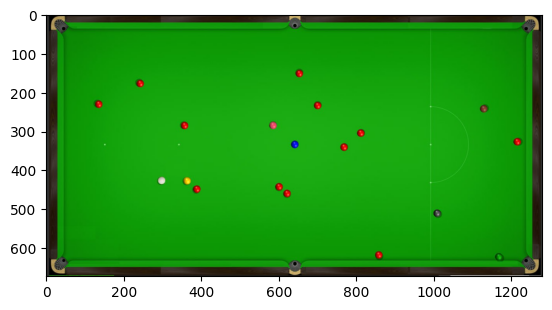

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
# Ignore RuntimeWarning
warnings.simplefilter("ignore", RuntimeWarning)

In [ ]:
def DmytroVarich(
    img: np.ndarray,
    target_color: str = "red",
) -> Tuple[int, dict, list, np.ndarray]:

  # Crop image
  img_clipped = img[20:-20, 30:-30].copy()

  # Convert to Lab space
  imgLab = color.rgb2lab(img_clipped)

  def get_balls_color(color: str) -> np.ndarray:
    """Function for selecting balls of a certain color"""
    if color == 'red':
      balls_color = np.logical_and.reduce((
          imgLab[:, :, 1] > 40,
          imgLab[:, :, 1] < 100,
          imgLab[:, :, 2] > 25,
          imgLab[:, :, 2] < 65
      ))
    elif color == 'yellow':
      balls_color = np.logical_and.reduce((
          imgLab[:, :, 1] > -20,
          imgLab[:, :, 1] < 25,
          imgLab[:, :, 2] > 50,
          imgLab[:, :, 2] < 100
      ))
    elif color == "blue":
      balls_color = np.logical_and.reduce((
          imgLab[:, :, 1] > -10,
          imgLab[:, :, 1] < 100,
          imgLab[:, :, 2] < -20,
          imgLab[:, :, 2] > -100
      ))
    elif color == "pink":
      balls_color = np.logical_and.reduce((
          imgLab[:, :, 1] > 30,
          imgLab[:, :, 1] < 100,
          imgLab[:, :, 2] < 20,
          imgLab[:, :, 2] > -10
      ))
    elif color == "white":
      balls_color = np.logical_and.reduce((
          imgLab[:, :, 0] > 80,
          imgLab[:, :, 1] > -10,
          imgLab[:, :, 1] < 10,
          imgLab[:, :, 2] > -10,
          imgLab[:, :, 2] < 10
      ))
    else:
      raise ValueError(f"Unsupported color: {color}. Choose from ['red', 'pink', 'yellow', 'green', 'brown', 'blue', 'gray', 'white']")
    return balls_color

  def get_hole_color() -> np.ndarray:
    """Function for getting hole of a black color"""
    hole_color = np.logical_and.reduce((
          imgLab[:, :, 0] < 3,

      ))
    return hole_color

  def apply_hough_circles(
      color: np.ndarray,
      minDist: int,
      param1: int,
      param2: int,
      minRadius: int,
      maxRadius: int
  ) -> np.ndarray:
    """Circle search function using the Hough transform"""
    gray_image = color.astype(np.uint8) * 255
    circles = cv2.HoughCircles(
        gray_image,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius
    )
    return circles

  def get_data_and_draw(
      circles: np.ndarray,
      img: np.ndarray,
      target_text: str,
      draw_circle: bool = False
  ) -> Tuple[int, list]:
    """Object counting and founding coordinates function"""
    coordinates = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
          center = (circle[0], circle[1])
          radius = circle[2]
          coordinates.append(center)
          if draw_circle:
            # cv2.circle(img, center, radius, (0, 255, 100), 2)
            cv2.circle(img, center, 10, (11, 242, 254), -1)
    else:
      return "No circles found. No coordinates"
    return len(circles[0]), coordinates

  def euclidean_distance(point1: tuple, point2: tuple) -> float:
    """Calculates the Euclidean distance between two points"""
    x1, y1 = map(float, point1)  # Преобразуем координаты в float
    x2, y2 = map(float, point2)

    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

  def highlight_points(img: np.ndarray, ball: Tuple[int, int], color: Tuple[int, ...]) -> np.ndarray:
    "Shades the nearest balls on the image"
    img = img.copy()
    cv2.circle(img, ball, 10, color, -1)
    return img

  # Get target color
  balls_color = get_balls_color(target_color)
  hole_color = get_hole_color()

  # Apply Hough Transform
  balls_circles = apply_hough_circles(balls_color, 20, 30, 10, 5, 10)
  hole_circles = apply_hough_circles(hole_color, 20, 30, 10, 2, 5)

  # Get number and their coordinates
  number_of_balls, balls_coor = get_data_and_draw(balls_circles, img_clipped, f'{target_color} balls', True)
  number_of_holes, hole_coor = get_data_and_draw(hole_circles, img_clipped, 'holes', False)

  # List for storing ball and hole distance data
  data_dist = []

  # For each hole, calculate the distance to each ball
  for hole in hole_coor:
    for ball in balls_coor:
      distance = euclidean_distance(hole, ball)
      rounded_distance = round(distance, 2)
      data_dist.append({
          "hole": hole,
          "ball": ball,
          "distance": rounded_distance
      })

  # Find the record with the minimum distance
  min_distance_entry = min(data_dist, key=lambda x: x["distance"])

  # Create a list of coordinates for the other balls
  other_balls_coor = [ball for ball in balls_coor if ball != min_distance_entry['ball']]

  # Select the ball with the minimum distance in the image
  img_result = highlight_points(img_clipped, min_distance_entry['ball'], (1, 75, 80))

  return number_of_balls, min_distance_entry, other_balls_coor, img_result

In [ ]:
def visualize_nearest_ball_and_hole(min_distance_entry, other_balls_coor, target_color, image_result, number):
    """
    Function to visualize the closest ball to the hole, other balls and the line between them.

    :param min_distance_entry: dictionary containing the coordinates of the nearest ball and the hole
    :param other_balls_coor: list of coordinates of other balls
    :param target_color: color of the target
    :param image_result: image to display
    :param number: number of balls
    """
    # Retrieve the coordinates of the nearest ball and hole
    nearest_ball_x = min_distance_entry['ball'][0]
    nearest_ball_y = min_distance_entry['ball'][1]
    hole_x = min_distance_entry['hole'][0]
    hole_y = min_distance_entry['hole'][1]

    # Vizualization
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_result)

    # Display the nearest ball
    ax.scatter(nearest_ball_x, nearest_ball_y, color='red', marker='x', s=100, label='Nearest Ball')
    ax.text(nearest_ball_x + 10, nearest_ball_y - 10, f"The nearest {target_color} ball to hole", fontsize=10, color='red')

    # Display the hole
    ax.plot(hole_x, hole_y, '*', color='red', markersize=15, label='Hole')

    # Draw a dotted line between the ball and the hole
    ax.plot([nearest_ball_x, hole_x], [nearest_ball_y, hole_y], linestyle='--', color='r', label='Dotted line')

    # Display other balls
    for i, (x, y) in enumerate(other_balls_coor):
        ax.scatter(x, y, color='red', marker='o', s=50, label='Other Balls' if i == 0 else "")
        ax.text(x + 10, y - 10, f"Other {target_color} balls", fontsize=10, color='red')

    # Display legend and title
    ax.legend()
    ax.set_title(f"Circles (Number of {target_color} balls: {number})")

    # Showing the image
    plt.show()

# Checking



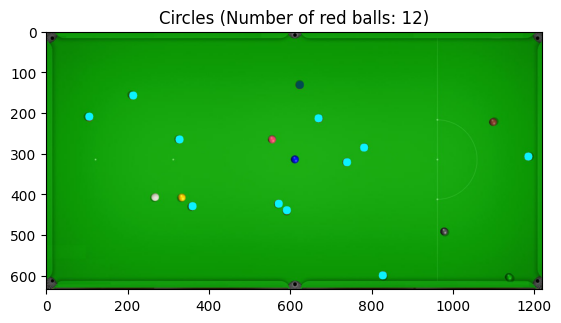

In [ ]:
target_color = 'red'
number, min_distance_entry, other_balls_coor, image_result = DmytroVarich(img, target_color)

# Vizualization (1)
plt.imshow(image_result)
plt.title(f"Circles (Number of {target_color} balls: {number})")
plt.show()

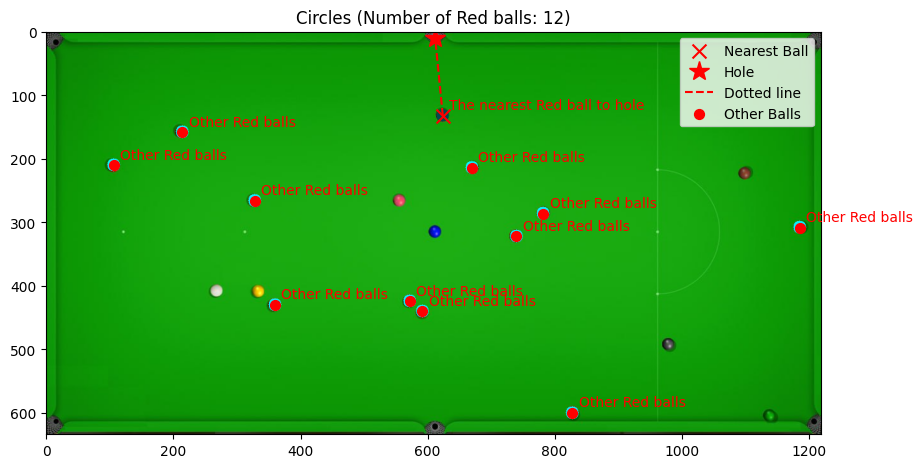

In [ ]:
# Vizualization (2)
visualize_nearest_ball_and_hole(min_distance_entry, other_balls_coor, 'Red', image_result, number)

# Yellow Balls Detecting

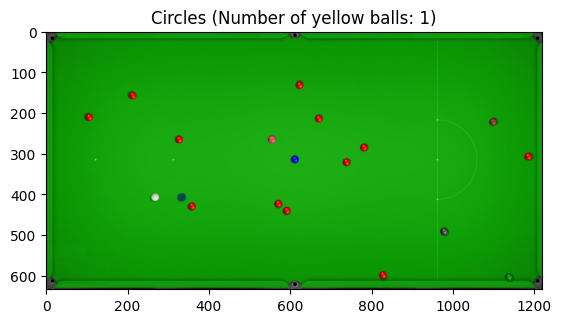

In [ ]:
target_color = 'yellow'
number, min_distance_entry, other_balls_coor, image_result = DmytroVarich(img, target_color)

# Vizualization (1)
plt.imshow(image_result)
plt.title(f"Circles (Number of {target_color} balls: {number})")
plt.show()

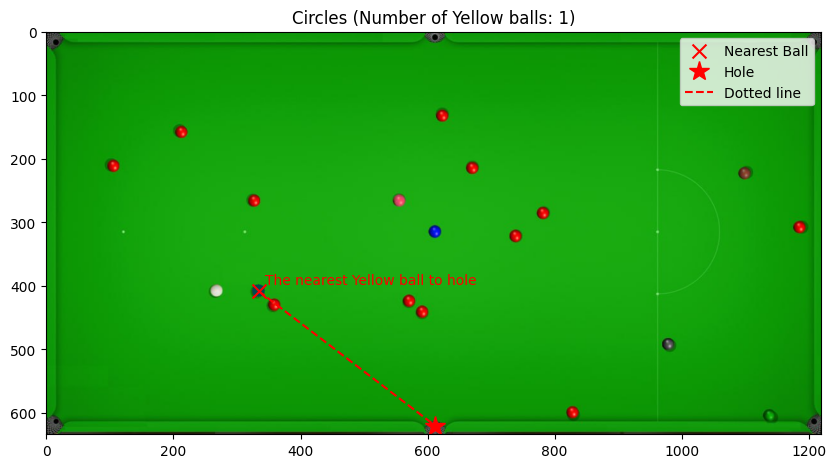

In [ ]:
# Vizualization (2)
visualize_nearest_ball_and_hole(min_distance_entry, other_balls_coor, 'Yellow', image_result, number)

# Blue Balls Detecting

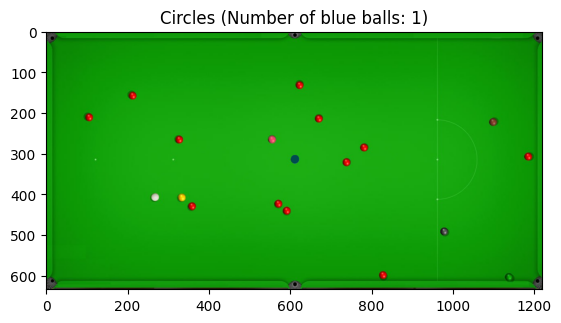

In [ ]:
target_color = 'blue'
number, min_distance_entry, other_balls_coor, image_result = DmytroVarich(img, target_color)

# Vizualization (1)
plt.imshow(image_result)
plt.title(f"Circles (Number of {target_color} balls: {number})")
plt.show()

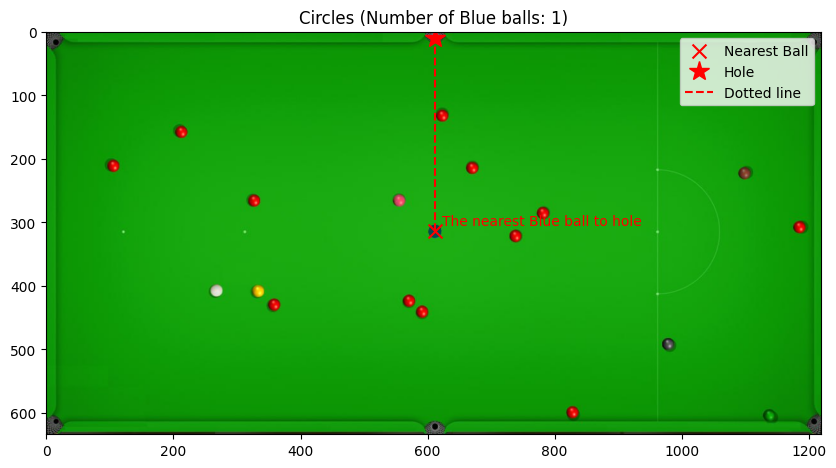

In [ ]:
# Vizualization (2)
visualize_nearest_ball_and_hole(min_distance_entry, other_balls_coor, 'Blue', image_result, number)

# Pink Balls Detecting

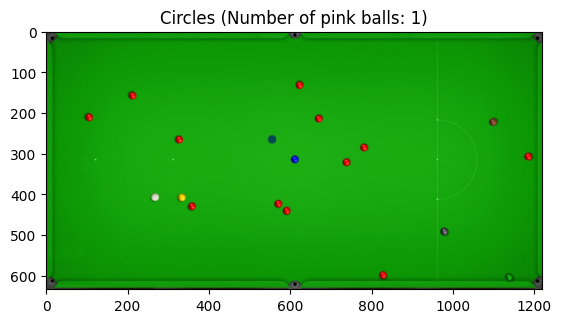

In [ ]:
target_color = 'pink'
number, min_distance_entry, other_balls_coor, image_result = DmytroVarich(img, target_color)

# Vizualization (1)
plt.imshow(image_result)
plt.title(f"Circles (Number of {target_color} balls: {number})")
plt.show()

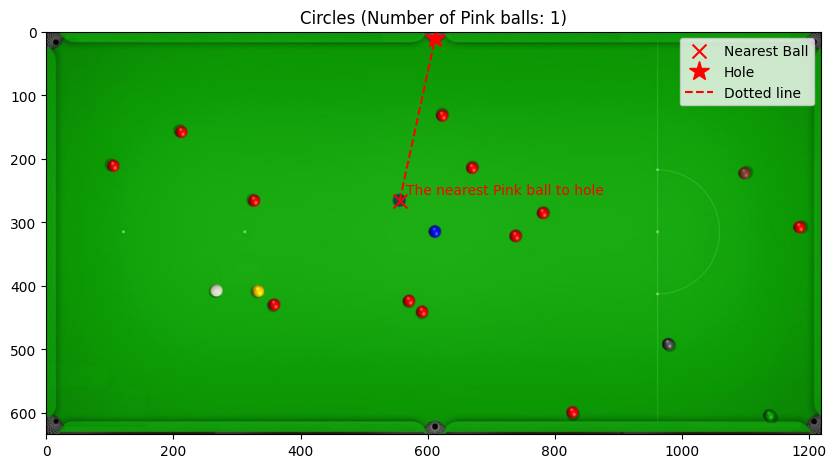

In [ ]:
# Vizualization (2)
visualize_nearest_ball_and_hole(min_distance_entry, other_balls_coor, 'Pink', image_result, number)

# White Balls Detecting

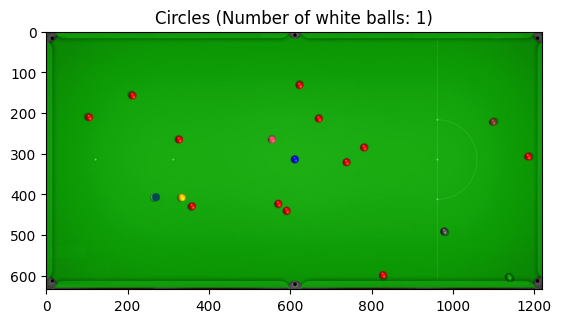

In [ ]:
target_color = 'white'
number, min_distance_entry, other_balls_coor, image_result = DmytroVarich(img, target_color)

# Vizualization (1)
plt.imshow(image_result)
plt.title(f"Circles (Number of {target_color} balls: {number})")
plt.show()

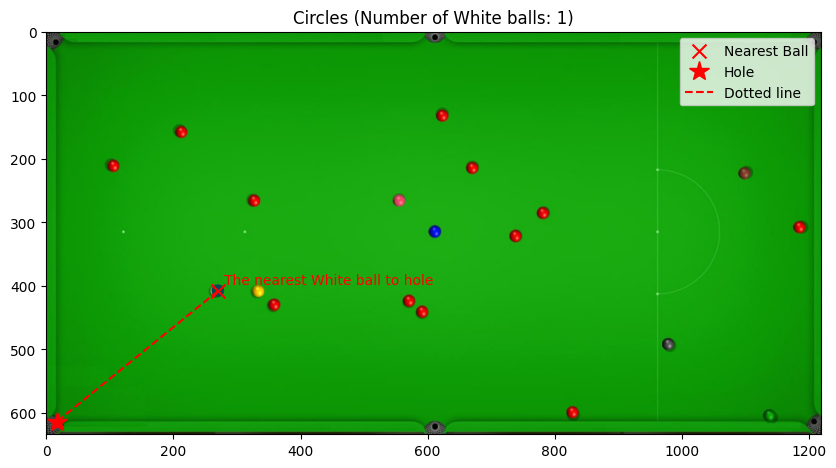

In [ ]:
# Vizualization (2)
visualize_nearest_ball_and_hole(min_distance_entry, other_balls_coor, 'White', image_result, number)